In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np
from porespy import generators
from tomo_encoders.misc_utils.feature_maps_vis import view_midplanes
import cupy as cp
import time
import h5py
from tomopy import project
sys.path.append('/data02/MyArchive/aisteer_3Dencoders/TomoEncoders/tomo_encoders/tasks/sparse_segmenter/')
from recon_subvol import fbp_filter, test_recon_patch
from tomo_encoders import DataFile, Patches
import os
import signal
import tomocg as pt

In [2]:
# # Use managed memory
# cp.cuda.set_allocator(cp.cuda.MemoryPool(cp.cuda.malloc_managed).malloc)

### Read projections data  

In [3]:
filename = 'mli_L206_HT_650_L3'
projs_path = '/data02/MyArchive/AM_part_Xuan/projs' 
binning = 1 
ntheta = 3000

In [4]:
# z, y, x
point = [500, 2000//binning, 2000//binning]
width = [32, 256, 256]
sz = slice(point[0], point[0] + width[0])

In [5]:
read_fpath = os.path.join(projs_path, filename + '_projs_bin%i_ntheta%i.hdf5'%(binning,ntheta))
with h5py.File(read_fpath, 'r') as hf:
    projs = np.asarray(hf['data'][:,sz,:])
    theta = np.asarray(hf['theta'][:])
    center = float(np.asarray(hf['center'][()]))

In [6]:
# make sure the width of projection is divisible by four after padding
proj_w = projs.shape[-1]
tot_width = int(proj_w*(1 + 0.25*2)) # 1/4 padding
tot_width = int(np.ceil(tot_width/8)*8) 
padding = int((tot_width - proj_w)//2)
projs = np.pad(projs, ((0,0),(0,0),(padding, padding)), mode = 'edge')

In [7]:
filt_projs = fbp_filter(cp.array(projs))

In [8]:
filt_projs.shape

(3000, 32, 6304)

In [9]:
test_proj = filt_projs.get()[:,10,:]
init_proj = projs[:,10,:]

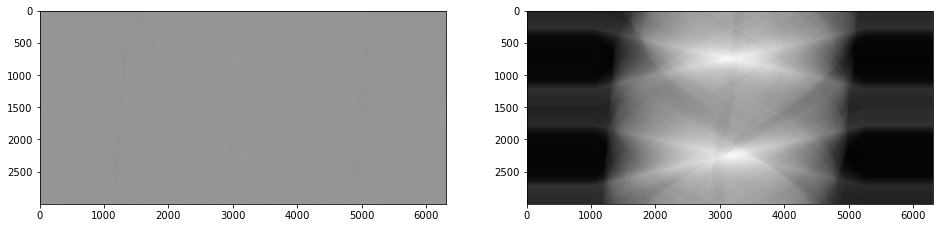

In [10]:
fig, ax = plt.subplots(1,2, figsize = (16,8))
ax[0].imshow(test_proj, cmap = 'gray')
ax[1].imshow(init_proj, cmap = 'gray')

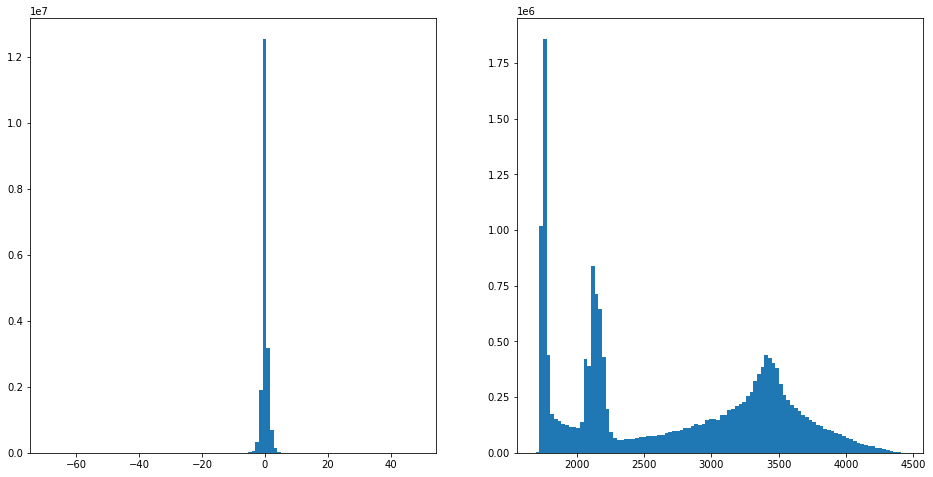

In [11]:
fig, ax = plt.subplots(1,2, figsize = (16,8))
h = ax[0].hist(test_proj.reshape(-1), bins = 100)
h = ax[1].hist(init_proj.reshape(-1), bins = 100)